In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
from xhistogram.xarray import histogram
from xmitgcm import open_mdsdataset

from sloped_MITgcm import *
from canyon_utils import *
from osse import *
from wmt import *

#### Constant parameters

In [3]:
Γ = 0.0008613659531090722
N = np.sqrt(g*α*Γ)
θ = 1.26E-3
f = -5.3e-5

h = 230
k0 = 5.2e-5
k1 = 1.8e-3

dx = 600.; dy = dx
delta_t = 15.

#### Load data

In [4]:
data_dir = f"../../MITgcm/experiments/rotated_BBTRE_canyon-tracer/run/"

diter = 5760*5
iters = np.int64(np.arange(72e5, 72e5+diter*100, diter))
ds = open_mdsdataset(data_dir,iters=iters,ignore_unknown_vars=True,prefix=["budgetDiag"], delta_t=delta_t)
ds = add_thalweg(ds)

extend_multiples = [-5, 1]
Lx = dx*ds.XC.size
ds = periodic_extend(ds, ['XC', 'XG'], Lx, extend_multiples)
ds, grid = add_rotated_coords(ds, θ)

ds['THETA_BG_C'] = Γ*ds['Zr']
ds['θ'] = ds['THETA'] + ds['THETA_BG_C']
ds['θ'] = ds['θ'].where(ds['hFacC'] != 0)
ds = add_temp_budget(ds, grid, Γ, θ)

ds['days'] = ds['time'].astype('float64')/(86400.*1e9) - 1250.

ds['Nsq'] = g*α*(Γ +
        (grid.diff(ds['THETA'].where(ds['hFacC']!=0.), 'Z', boundary='fill')) /
        grid.interp(-ds['drF'], 'Z', boundary='extend')
)

ds['Msq'] = g*α*(Γ*np.sin(θ) +
        (grid.diff(ds['THETA'].where(ds['hFacC']!=0.), 'X', boundary='periodic')) /
        grid.diff(ds['XC'], 'X', boundary='periodic')
)

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/xmitgcm/mds_store.py:178: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':


#### Interpolate to heigh-above-bottom coordinates

In [5]:
ds = add_hab_coordinates(ds, grid, vert_coord='Zl', gridface='C')
ds['Nsq'] = ds['Nsq'].assign_coords({'Zl_habC': ds['Zl_habC']}).chunk({'Zl':-1})
ds['Nsq_hab'] = hab_interp(ds['Nsq'], vert_coord='Zl')

/nobackup1b/users/hdrake/bblturb/notebooks/BBTRE_physics_analysis/sloped_MITgcm.py:64: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  da_itp = xr.apply_ufunc(


In [6]:
ds = add_hab_coordinates(ds, grid, vert_coord='Z', gridface='C')
ds['θ'] = ds['θ'].assign_coords({'Z_habC': ds['Z_habC']}).chunk({'Z':-1})
ds['θ_hab'] = hab_interp(ds['θ'], vert_coord='Z')

/nobackup1b/users/hdrake/bblturb/notebooks/BBTRE_physics_analysis/sloped_MITgcm.py:64: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  da_itp = xr.apply_ufunc(


#### Select illustrative temperature classes

In [7]:
HAB = 230
ds['Nsq_bot'] = ds['Nsq_hab'].sel(habC=HAB, method='nearest')
Nsqbot = ds['Nsq_bot'].sel(XC=slice(-1400*dx, 500*dx)).isel(time=-1).compute()

ds['θ_bot'] = ds['θ_hab'].isel(habC=2)
θbot = ds['θ_bot'].sel(XC=slice(-1400*dx, 500*dx)).isel(time=-1).compute()
θ_lo_bins = [0.6, 0.7]
θ_hi_bins = [0.25, 0.35]

loMask = (θbot >= θ_lo_bins[0]) & (θbot < θ_lo_bins[1]).compute()
hiMask = (θbot >= θ_hi_bins[0]) & (θbot < θ_hi_bins[1]).compute()

#### Approximate WMT calculation

In [8]:
dθ = 0.05
θlevs = np.arange(0.-dθ, 1.+dθ, dθ)

incrop = histogram(
    ds['θ_bot'].isel(time=-1),
    bins=[θlevs],
    density=False
).load().rename({'θ_bot_bin': 'θ_hab_bin'})*dx*dy;

In [12]:
Nsq_av = (
    histogram(
        ds['θ_bot'].isel(time=-1),
        bins=[θlevs],
        dim=('XC', 'YC',),
        weights=ds['Nsq_bot'].isel(time=-1)*ds['rA'],
    ) / 
    histogram(
        ds['θ_bot'].isel(time=-1),
        bins=[θlevs],
        dim=('XC', 'YC',),
        weights=ds['rA'],
    )
).load().rename({'θ_bot_bin': 'θ_hab_bin'});

In [9]:
Lx, Ly = ds.XC.size*dx, ds.YC.size*dy
cint = k0*Γ*np.cos(θ)*Ly*Lx
cbot = k1*Γ*np.cos(θ)*Ly*Lx

Θrepeat = 800*dx*Γ*np.sin(θ)
lo_bins = (np.array([θ_lo_bins[0], θ_lo_bins[0]]), np.array([θ_lo_bins[1], θ_lo_bins[1]]))
hi_bins = (np.array([θ_hi_bins[0], θ_hi_bins[0]]), np.array([θ_hi_bins[1], θ_hi_bins[1]]))

### Load diagnosed WMT

In [11]:
bg_incrop = Ly*dθ/(Γ*np.sin(θ))

wmt_approx = (1/dθ) * k1 * (Nsq_av/(g*α)) * incrop
wmt_bg = (1/dθ) * k1 * Γ * bg_incrop

wmt_dict = {}
for k in ['total', 'canyon', 'flanks', 'outside']:
    wmt_dict[k] = xr.open_dataset(f"../../data/BBTRE-physics/wmt_{k}.nc")
    
total_area = wmt_dict['total'].area

#### Plotting

In [27]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

greys = cm.get_cmap('Greys_r', 256)
greys = ListedColormap(greys(np.linspace(0.2, 1, 256)))

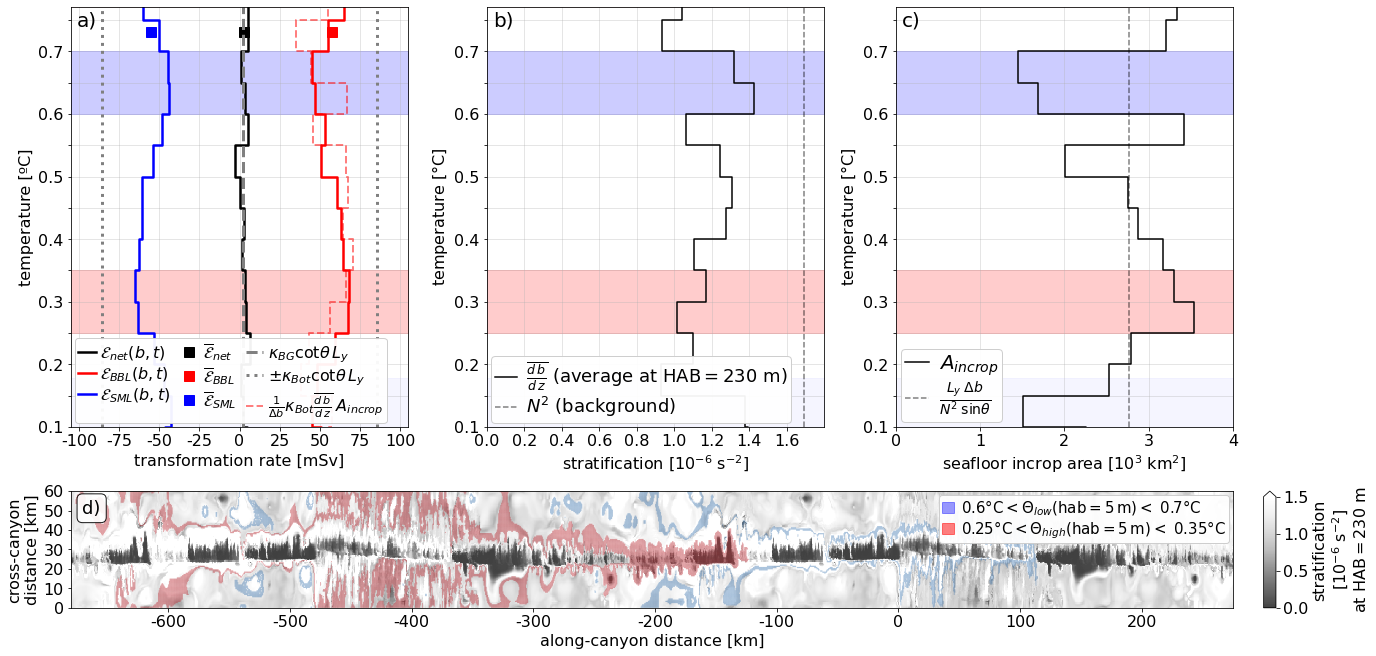

In [28]:
fig = plt.figure(figsize=(19,9), constrained_layout=True)
gs = fig.add_gridspec(3, 3)

ylims = [0.10, 0.15+Θrepeat+0.1]

########
ax1 = fig.add_subplot(gs[0:2, 0])

xlims = [-105*1e3, 105*1e3]
ax1.fill_between(xlims, lo_bins[0], lo_bins[1], alpha=0.2, color="b")
ax1.fill_between(xlims, lo_bins[0]-Θrepeat, lo_bins[1]-Θrepeat, alpha=0.04, color="b")
ax1.fill_between(xlims, hi_bins[0], hi_bins[1], alpha=0.2, color="r")
ax1.fill_between(xlims, hi_bins[0]+Θrepeat, hi_bins[1]+Θrepeat, alpha=0.05, color="r")
ax1.set_xlim(xlims)

d = xr.Dataset(wmt_dict['total'])
ax1.step(d['E_net'].mean('time').values, d['θ_bin'].values+dθ/2, where='post', color='k', label=r"$\mathcal{E}_{net}(b, t)$", lw=2.5)
ax1.step(d['E_BBL'].mean('time').values, d['θ_bin'].values+dθ/2, where='post', color='r', label=r"$\mathcal{E}_{BBL}(b, t)$", lw=2.5)
ax1.step(d['E_SML'].mean('time').values, d['θ_bin'].values+dθ/2, where='post', color='b', label=r"$\mathcal{E}_{SML}(b, t)$", lw=2.5)

ax1.plot([d['E_net'].mean(['θ_bin', 'time'])],[0.73], "ks", markersize=10, label=r"$\overline{\mathcal{E}}_{net}$")
ax1.plot([d['E_BBL'].mean(['θ_bin', 'time'])],[0.73], "rs", markersize=10, label=r"$\overline{\mathcal{E}}_{BBL}$")
ax1.plot([d['E_SML'].mean(['θ_bin', 'time'])],[0.73], "bs", markersize=10, label=r"$\overline{\mathcal{E}}_{SML}$")

ax1.axvline(x=cint/(Γ*np.sin(θ)*Lx), color="grey", lw=3., linestyle = "--", label=r"$\kappa_{BG}\cot{\theta}\, L_{y}$")
ax1.axvline(x=cbot/(Γ*np.sin(θ)*Lx), color="grey", lw=3., linestyle = ":", label=r"$\pm \kappa_{Bot}\cot{\theta}\, L_{y}$")
ax1.axvline(x=-cbot/(Γ*np.sin(θ)*Lx), color="grey", lw=3., linestyle = ":")

ax1.step(wmt_approx.values, wmt_approx['θ_hab_bin'].values+dθ/2, linestyle="--", color="r", label=r"$\frac{1}{\Delta b} \kappa_{Bot} \overline{\frac{d\, b}{d\, z}} \; A_{incrop}$", lw=2., alpha=0.5)

ax1.set_xlabel("transformation rate [mSv]")
ax1.set_ylabel("temperature [ºC]")
ax1.set_xticks(np.arange(-100e3, 120e3, 25e3));
ax1.set_xticklabels(np.arange(-100, 120, 25));
ax1.set_yticks(θlevs[1:]);
ax1.set_yticklabels([round(lev,1) if not(i%2) else None for i,lev in enumerate(θlevs[1:], start=0)]);
ax1.set_ylim(ylims)
ax1.grid(True, alpha=0.4)
ax1.set_title("")
ax1.legend(
    loc='lower left', bbox_to_anchor=(0, 0), framealpha=0.95, 
    ncol=3, handlelength=1.1, handletextpad=0.3, columnspacing=0.6, labelspacing=0.15,
    borderpad=0.2, borderaxespad=0.25
)
ax1.annotate("a)", xy=(0.0175, 0.955), xycoords='axes fraction', fontsize=20)

########
ax2 = fig.add_subplot(gs[0:2, 1])

ax2.step(Nsq_av.values, Nsq_av['θ_hab_bin'].values+dθ/2, where='post', color='k', label=r"$\overline{\frac{d\, b}{d\, z}}$"+fr" (average at HAB$={HAB}$ m)")
ax2.axvline(N**2, linestyle="--", color="k", alpha=0.5, label="$N^{2}$ (background)")

xlims = [0, 1.8e-6]
ax2.fill_between(xlims, lo_bins[0], lo_bins[1], alpha=0.2, color="b")
ax2.fill_between(xlims, lo_bins[0]-Θrepeat, lo_bins[1]-Θrepeat, alpha=0.04, color="b")
ax2.fill_between(xlims, hi_bins[0], hi_bins[1], alpha=0.2, color="r")
ax2.fill_between(xlims, hi_bins[0]+Θrepeat, hi_bins[1]+Θrepeat, alpha=0.05, color="r")
ax2.set_xticks(np.arange(xlims[0], xlims[1], 0.2e-6))
ax2.set_xticklabels(np.round(np.arange(xlims[0]*1e6, xlims[1]*1e6, 0.2), 1));
ax2.set_xlim(xlims)
ax2.set_yticks(θlevs[1:])
ax2.set_yticklabels([round(lev,1) if not(i%2) else None for i,lev in enumerate(θlevs[1:], start=0)])
ax2.set_ylim(ylims)
ax2.set_xlabel("stratification [10"+r"$^{-6}$ s$^{-2}$]")
ax2.set_ylabel(fr"temperature [$\degree$C]")
ax2.grid(True, alpha=0.4)
ax2.legend(handlelength=1.2, fontsize=18, labelspacing=0.1, handletextpad=0.5, borderpad=0.2, borderaxespad=0.25, loc='lower left', framealpha=0.95)
ax2.annotate("b)", xy=(0.0175, 0.955), xycoords='axes fraction', fontsize=20)

########
ax3 = fig.add_subplot(gs[0:2, 2])

ax3.step(incrop.values*1e-9, incrop['θ_hab_bin'].values+dθ/2, where='post', color='k', label=r"$A_{incrop}$")
ax3.axvline(bg_incrop*1e-9, color='k', alpha=0.5, linestyle='--', label=r"$\frac{L_{y}\; \Delta b}{N^{2}\; \sin{\theta}}$")

xlims = ax3.set_xlim(0, 4.)

ax3.fill_between(xlims, lo_bins[0], lo_bins[1], alpha=0.2, color="b")
ax3.fill_between(xlims, lo_bins[0]-Θrepeat, lo_bins[1]-Θrepeat, alpha=0.04, color="b")
ax3.fill_between(xlims, hi_bins[0], hi_bins[1], alpha=0.2, color="r")
ax3.fill_between(xlims, hi_bins[0]+Θrepeat, hi_bins[1]+Θrepeat, alpha=0.05, color="r")
ax3.set_xlim(xlims)
ax3.set_yticks(θlevs[1:])
ax3.set_yticklabels([round(lev,1) if not(i%2) else None for i,lev in enumerate(θlevs[1:], start=0)])
ax3.set_ylim(ylims)
ax3.set_xlabel("seafloor incrop area [10$^{3}$ "+fr"km$^{2}$]")
ax3.set_ylabel(fr"temperature [$\degree$C]")
ax3.grid(True, alpha=0.4)
ax3.legend(handlelength=1.2, fontsize=20, labelspacing=0.1, handletextpad=0.5, borderpad=0.2, borderaxespad=0.25, loc='lower left', framealpha=0.95)
ax3.annotate("c)", xy=(0.0175, 0.955), xycoords='axes fraction', fontsize=20)

########
ax4 = fig.add_subplot(gs[2, :])

q = (Nsqbot*1e6).plot(ax=ax4, cmap=greys, vmin=0, vmax=1.5, extend="max")
q.colorbar.set_label(
"stratification"
"\n"
r"[10$^{-6}$ s$^{-2}$]"
"\n"
fr"at HAB$={HAB}$ m"
)
q = loMask.where(loMask).plot(ax=ax4, alpha=0.4, cmap="RdBu", vmin=0, vmax=1.1,linewidth=0,rasterized=True, antialiased=True)
ax4.fill_between([],[],[],color="b",alpha=0.4,label=fr"${θ_lo_bins[0]}$"+r"$\degree$C$ < \Theta_{low}($hab$=5\, $m$) < $"+fr" ${θ_lo_bins[1]}$"+r"$\degree$C")
ax4.fill_between([],[],[],color="r",alpha=0.5,label=fr"${θ_hi_bins[0]}$"+r"$\degree$C$ < \Theta_{high}($hab$=5\, $m$) < $"+fr" ${θ_hi_bins[1]}$"+r"$\degree$C")
q.colorbar.remove()
q = hiMask.where(hiMask).plot(ax=ax4, alpha=0.5, cmap="RdBu_r", vmin=0, vmax=1.15,linewidth=0,rasterized=True, antialiased=True)
q.colorbar.remove()

ax4.set_title("")
ax4.set_ylabel("cross-canyon\ndistance [km]")
ax4.set_yticks(np.arange(0., 70e3, 10e3))
ax4.set_yticklabels(np.arange(0, 70, 10))
ax4.set_ylim([0e3, 60e3])

ax4.set_xlabel("along-canyon distance [km]")
ax4.set_xticks(np.arange(-700e3, 300e3, 100e3))
ax4.set_xticklabels(np.arange(-700, 300, 100))
ax4.set_xlim([-680e3, 275e3])
ax4.legend(loc="upper right", fontsize=15, handlelength=0.8, handletextpad=0.5, borderpad=0.2, borderaxespad=0.25, labelspacing=0.1, framealpha=0.95)
ax4.annotate("d)", xy=(0.01, 0.81), xycoords='axes fraction', fontsize=18, bbox = dict(boxstyle="round", alpha=0.9, fc="1.", ec=None))

plt.savefig("../../figures/BBTRE/watermass_transformations.png", bbox_tight="inches", dpi=150.)

#### WMT-per-unit area

In [157]:
label_longnames = {
    'total': 'total',
    'canyon': 'canyon\ntrough',
    'flanks': 'canyon\nflanks',
    'outside': 'outside of\ncanyon'
}

def percent(n):
    return str(np.int64(np.round(n*100)))

colors = ["C1", "C2", "C3", "C4", "C5"]

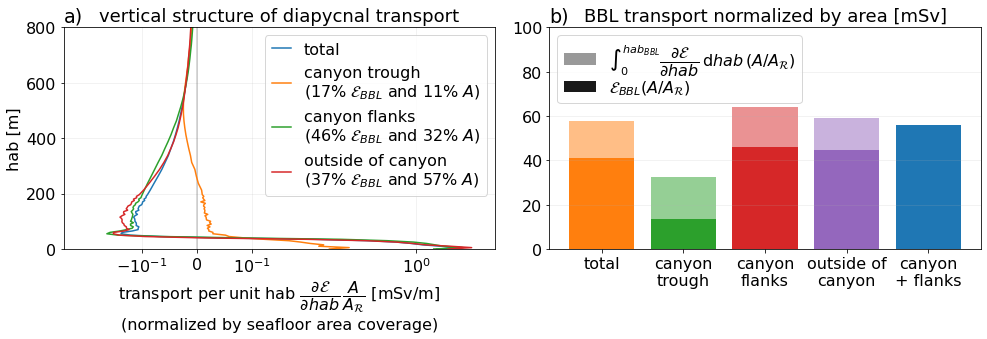

In [182]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.axvline(0., color="k", alpha=0.2, lw=1.5)
for i, (k,v) in enumerate(wmt_dict.items()):
    pT = percent(v["E_hab"].mean()/wmt_dict["total"]["E_hab"].mean())
    pA = percent(v.area/wmt_dict["total"].area)
    label = label_longnames[k].replace("\n", " ")
    if k!="total": label=f"{label}\n"+fr"({pT}% $\mathcal{{E}}_{{BBL}}$ and {pA}% $A$)"
    else: label=k
    (v["E_hab"].mean(['time'])/v["dZ_habC_bin"]*(wmt_dict["total"].area/wmt_dict[k].area)*1e-3).plot(y="Z_habC_bin", label=label)
    
(wmt_dict["canyon"]["E_hab"].mean(['time'])/v["dZ_habC_bin"]*(wmt_dict["total"].area/wmt_dict[k].area)*1e-3)
plt.xscale('symlog', linthresh=1e-1, linscale=0.3)
plt.grid(True, alpha=0.2)
plt.xlabel(
    r"transport per unit hab $\dfrac{\partial \mathcal{E}}{\partial hab} \, \dfrac{A}{A_{\mathcal{R}}}$ [mSv/m]"
    "\n(normalized by seafloor area coverage)"
)
plt.ylabel("hab [m]")
plt.ylim(0, 800)
plt.xlim(-0.3,3)
plt.legend(loc="upper right", handlelength=1.2)
plt.title("a)", loc="left")
plt.title("vertical structure of diapycnal transport", fontsize=18)

plt.subplot(1,2,2)

plt.grid(True, alpha=0.2, axis="y")

for i, (k,v) in enumerate(wmt_dict.items()):
    E_hab = v["E_hab"].mean(['time'])
    E_hab_BBL = E_hab.where(E_hab>0., 0.).sum()
    plt.bar(i, v['E_BBL'].mean(['time', 'θ_bin']).values*(total_area/wmt_dict[k].area)*1e-3, color=colors[i], alpha=0.5)
    plt.bar(i, E_hab_BBL*(total_area/wmt_dict[k].area)*1e-3, color=colors[i])
plt.bar(i+1, (wmt_dict["canyon"]['E_BBL']+wmt_dict["flanks"]['E_BBL']).mean(['time', 'θ_bin']).values*(total_area/(wmt_dict["canyon"].area+wmt_dict["flanks"].area))*1e-3)
    
plt.fill_between([],[], [], facecolor="k", alpha=0.4, label=r"$\int_{0}^{hab_{BBL}} \dfrac{\partial \mathcal{E}}{\partial hab}\, $d$hab\, (A / A_{\mathcal{R}})$")
plt.fill_between([],[], [], facecolor="k", alpha=0.9, label=r"$\mathcal{E}_{BBL} (A / A_{\mathcal{R}})$")
plt.legend(loc="upper left", labelspacing=0.12)

plt.title(
    "BBL transport normalized by area [mSv]",
    fontsize=18
)
plt.title("b)", loc="left")
plt.xticks(np.arange(0,5), list(label_longnames.values())+["canyon\n+ flanks"])
plt.ylim(0, 100)

plt.tight_layout()
plt.savefig("../../figures/BBTRE/BBL_wmt_efficacy.png", dpi=150., bbox_inches='tight')